In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

pg.utils.units.quants['vel']['cMap'] = 'jet'

In [2]:
# Acquisition parameters
bh_spacing = 30
bh_length = 40
sensor_spacing = 2.67

world = mt.createRectangle(start=[0, -(bh_length + 3)], end=[bh_spacing, 0.0],
                           marker=0)

depth = -np.arange(sensor_spacing, bh_length + sensor_spacing, sensor_spacing)

sensors = np.zeros((len(depth) * 2, 2))  # two boreholes
sensors[len(depth):, 0] = bh_spacing  # x
sensors[:, 1] = np.hstack([depth] * 2)  # y

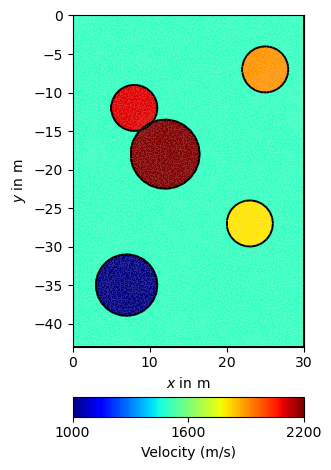

In [3]:
# Create forward model and mesh
c1 = mt.createCircle(pos=(23, -27), radius=3, nSegments=25, marker=1)
c2 = mt.createCircle(pos=(8, -12), radius=3, nSegments=25, marker=2)
c3 = mt.createCircle(pos=(12, -18), radius=4.5, nSegments=25, marker=3)
c4 = mt.createCircle(pos=(25.0, -7.0), radius=3, nSegments=25, marker=4)
c5 = mt.createCircle(pos=(7, -35), radius=4, nSegments=25, marker=5)
geom = world + c1 + c2 + c3 + c4 + c5
for sen in sensors:
    geom.createNode(sen)

mesh_fwd = mt.createMesh(geom, quality=34, area=0.25)
model = np.array([1500, 1800, 2100, 2200, 1900, 1000])[mesh_fwd.cellMarkers()]
ax, cb = pg.show(mesh_fwd, model, logScale=False,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

In [4]:
scheme = tt.createCrossholeData(sensors)

17/10/25 - 23:06:32 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


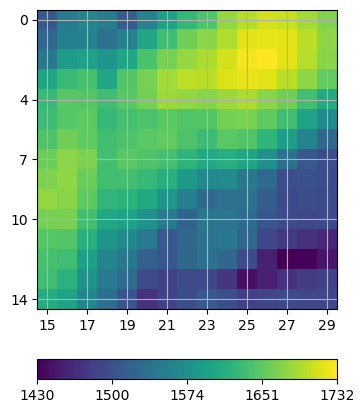

In [5]:
mgr = tt.TravelTimeManager()
data = tt.simulate(mesh=mesh_fwd, scheme=scheme, slowness=1./model,
                   secNodes=4, noiseLevel=0.0015, noiseAbs=1e-5, seed=1337)

ax, cb = tt.showVA(data, usePos=False)

17/10/25 - 23:06:59 - pyGIMLi - INFO - Found 1 regions.
17/10/25 - 23:06:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/10/25 - 23:06:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
17/10/25 - 23:06:59 - pyGIMLi - INFO - Create constant starting model: 0.0006225163207441654
17/10/25 - 23:06:59 - pyGIMLi - INFO - Created startmodel from forward operator:2880, min/max=0.000623/0.000623
17/10/25 - 23:06:59 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x0000029E569E5300>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 0.02/0.03
min/max (error): 0.18%/0.21%
min/max (start model): 6.2e-04/6.2e-04
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  571.98
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   38.15 (dPhi = 92.62%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.87 (dPhi = 75.59%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.60 (dPhi = 53.81%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.20 (dPhi = 12.70%) lam: 1000.0
------------------------------------------------------

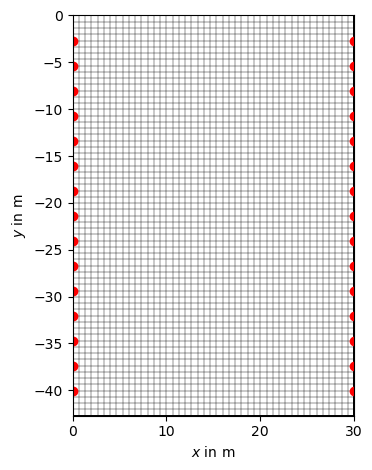

In [6]:
refinement = 0.25
x = np.arange(0, bh_spacing + refinement, sensor_spacing * refinement)
y = -np.arange(0.0, bh_length + 3, sensor_spacing * refinement)
mesh = pg.meshtools.createGrid(x, y)

ax, _ = pg.show(mesh, hold=True)
ax.plot(sensors[:, 0], sensors[:, 1], "ro")

invmodel = mgr.invert(data, mesh=mesh, secNodes=3, lam=1000, zWeight=1.0,
                      useGradient=False, verbose=True)
print("chi^2 = {:.2f}".format(mgr.inv.chi2()))  # Look at the data fit

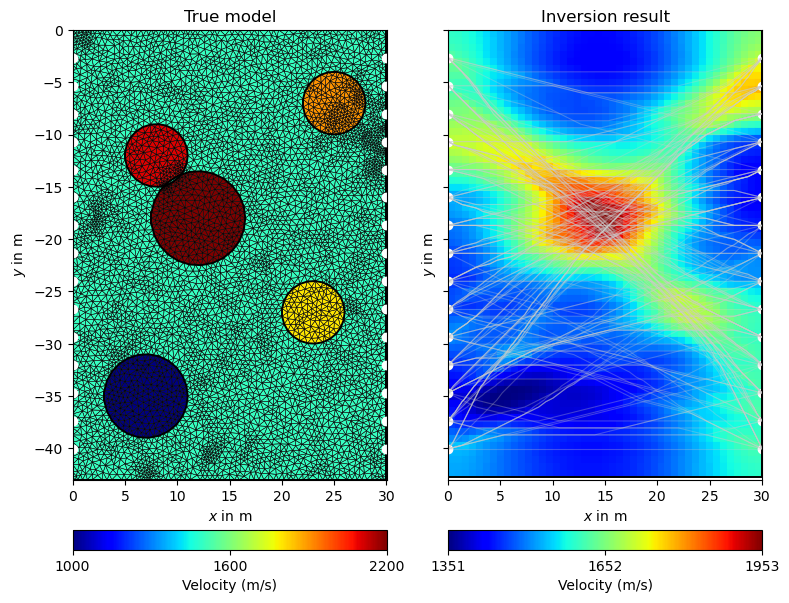

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

ax, cb = pg.show(mesh_fwd, model, ax=ax1, showMesh=True,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

for ax in (ax1, ax2):
    ax.plot(sensors[:, 0], sensors[:, 1], "wo")

mgr.showResult(ax=ax2, logScale=False, nLevs=3)
mgr.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
fig.tight_layout()

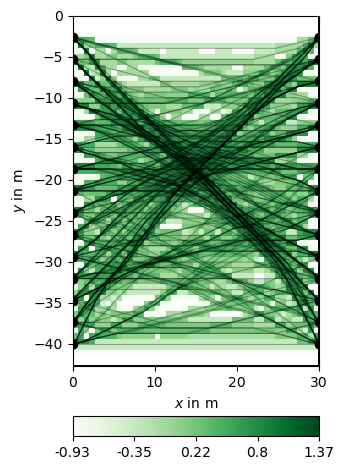

In [8]:
fig, ax = plt.subplots()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.drawRayPaths(ax=ax, color="k", alpha=0.3)
p = ax.plot(sensors[:, 0], sensors[:, 1], "ko")